In [189]:
# Import modules

#import wget
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import sciann as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [86]:
# Download dataset and load it as a Pandas DataFrame

#wget.download(https://opendata-renewables.engie.com//media/datasets/d543716b-368d-4c53-8fb1-55addbe8d3ad.zip)
#wget.download(https://opendata-renewables.engie.com//media/datasets/01c55756-5cd6-4f60-9f63-2d771bb25a1a.zip)

data_turbines = pd.read_csv('../Dataset/la-haute-borne-data-2013-2016.csv',sep=';')
print(data_turbines.shape)

(840380, 138)


In [204]:
# Prepare data

from numpy import float64

data_turbine1 = data_turbines[data_turbines["Wind_turbine_name"]=="R80711"]
data_turbine2 = data_turbines[data_turbines["Wind_turbine_name"]=="R80721"]
data_turbine3 = data_turbines[data_turbines["Wind_turbine_name"]=="R80736"]
data_turbine4 = data_turbines[data_turbines["Wind_turbine_name"]=="R80790"]
#print(data_turbine1.shape)
#print(data_turbine2.shape)
#print(data_turbine3.shape)
#print(data_turbine4.shape)
#print(data_turbine1.head(5))

# Extract the desired variables
data_turbine1 = data_turbines[['Ws_avg','Ba_avg','Ds_avg','Rm_avg']]

# Drop all rows with NaN values
data_turbine1 = data_turbine1.dropna()
data_turbine1 = data_turbine1.dropna(axis=0)

# Remove outliers
for col_name in ["Ws_avg","Ba_avg","Ds_avg","Rm_avg"]:
    q_low = data_turbine1[col_name].quantile(0.1)
    q_hi  = data_turbine1[col_name].quantile(0.9)
    data_turbine1 = data_turbine1[(data_turbine1[col_name] < q_hi) & (data_turbine1[col_name] > q_low)]

# Define inputs and outputs

X_data = data_turbine1[['Ws_avg','Ba_avg','Ds_avg']]
Y_data = data_turbine1[['Rm_avg']]

# Convert data to numpy arrays
X_data = X_data.to_numpy(dtype='float64')
Y_data = Y_data.to_numpy(dtype='float64')
#print(X_data.shape)
#print(Y_data.shape)

# Normalization of inputs and outputs

#print("x1:", min(X_data[:,0]), max(X_data[:,0]), np.average(X_data[:,0]), np.std(X_data[:,0]) )
#print("x2:", min(X_data[:,1]), max(X_data[:,1]), np.average(X_data[:,1]), np.std(X_data[:,1]) )
#print("x3:", min(X_data[:,2]), max(X_data[:,2]), np.average(X_data[:,2]), np.std(X_data[:,2]) )
#print("y:", min(Y_data[:,0]), max(Y_data[:,0]), np.average(Y_data[:,0]), np.std(Y_data[:,0]) )

x1_avrg = np.average(X_data[:,0])
x1_std = np.std(X_data[:,0])
x2_avrg = np.average(X_data[:,1])
x2_std = np.std(X_data[:,1])
x3_avrg = np.average(X_data[:,2])
x3_std = np.std(X_data[:,2])
y_avrg = np.average(Y_data[:,0])
y_std = np.std(Y_data[:,0])

X_data[:,0] = ( X_data[:,0] - x1_avrg ) / x1_std
X_data[:,1] = ( X_data[:,1] - x2_avrg ) / x2_std
X_data[:,2] = ( X_data[:,2] - x3_avrg ) / x3_std
Y_data[:,0] = ( Y_data[:,0] - y_avrg ) / y_std

# Split the data in training and test/validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

train_size = len(X_train[:,0])
test_size = len(X_test[:,0])

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(340414, 3)
(340414, 1)
(85104, 3)
(85104, 1)


In [209]:
# Set up the NN arquitecture to fit the data

from pickletools import optimize

Vw = sn.Variable('Vw')
theta = sn.Variable('theta')
Wwt = sn.Variable('Wwt')

Torque = sn.Functional('Torque',variables=[Vw,theta,Wwt],hidden_layers=[20,20],activation='tanh')

# Set up the optimization algorithm
data1 = sn.Data(Torque)
model = sn.SciModel(inputs=[Vw,theta,Wwt], targets=data1,loss_func='mae',optimizer='adam')

model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Vw (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 theta (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 Wwt (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 concat_24 (Concatenate)        (None, 3)            0           ['Vw[0][0]',                     
                                                                  'theta[0][0]',           

(800, 3)
(200, 3)

Total samples: 800 
Batch size: 64 
Total batches: 13 


Epoch 376: ReduceLROnPlateau reducing learning rate to 0.009999999776482582.

Epoch 634: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 773: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.


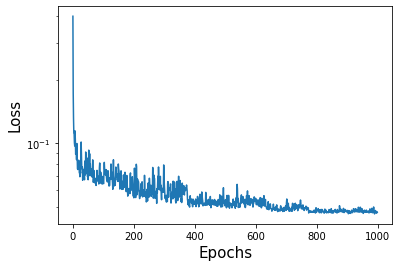

In [210]:
# Train the model 

from tabnanny import verbose

train_size = 1600
test_size = 400

X_train = X_train[0:train_size]
Y_train = Y_train[0:train_size]
X_test = X_train[0:test_size]
Y_test = Y_train[0:test_size]

print(X_train.shape)
print(X_test.shape)

running = model.train([X_train[:,0],X_train[:,1],X_train[:,2]],Y_train[:,0],batch_size=64,learning_rate=0.02, epochs=1000,verbose=0)

plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.semilogy(running.history['loss'])
plt.show()

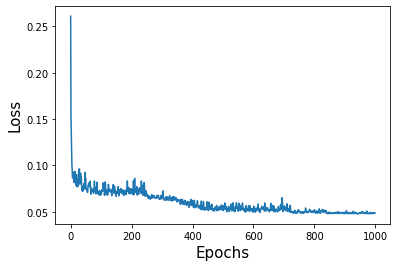

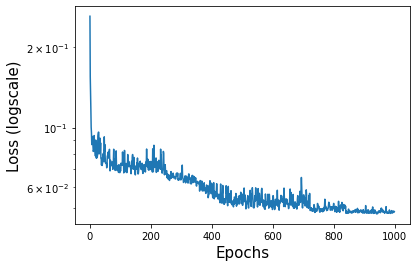

In [207]:
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.plot(running.history['loss'])
plt.show()
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss (logscale)',fontsize=15)
plt.semilogy(running.history['loss'])
plt.show()

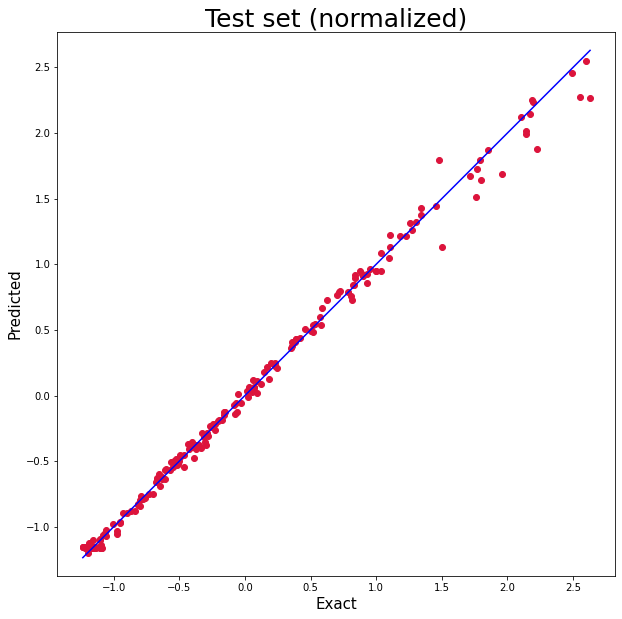

Normalized test MAE: 0.04530885486523393
Normalized test MSE: 0.005479567610158593
Normalized test MRE: 11.471848986021646


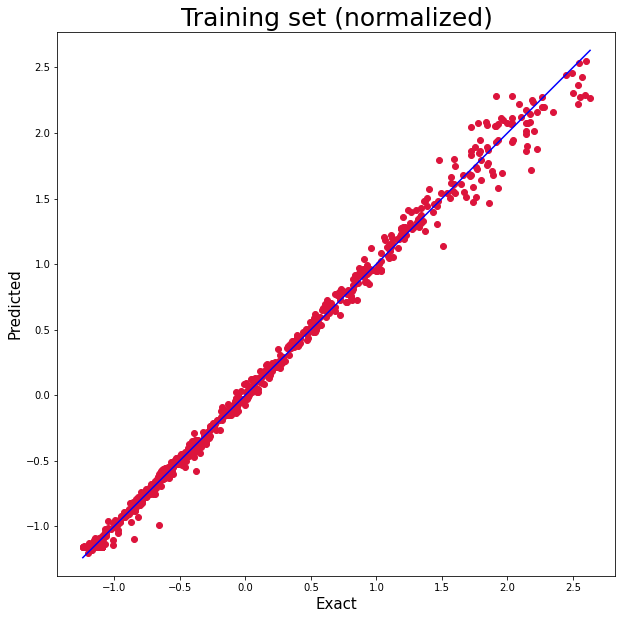

Normalized train MAE: 0.04686541435640883
Normalized train MSE: 0.005626807258357684
Normalized test MRE: 22.24172760116494


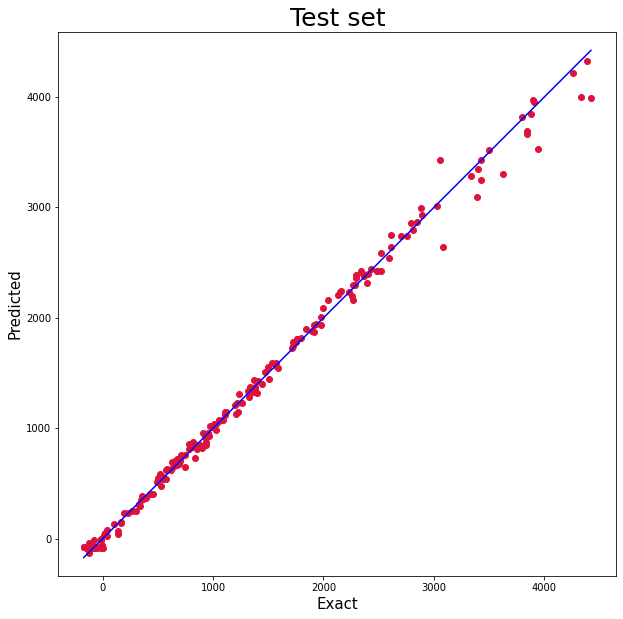

Test MAE: 53.865273865347646
Test MSE: 7744.580964733559
Test MRE: 36.43435612728695
[ 0.55033952  1.03539547  0.85728112  0.93599394  1.00877772  1.01224128
  0.95349357  1.0071621   1.01179166  1.06418469  0.97542966  0.92688626
  0.53527978  1.03130845  0.45271454  0.97450644  1.00565139  0.87576762
  1.054188    1.00380237  1.02026338  1.0536257   1.09014955  0.98571395
  0.92317987  1.08367908  0.94553738  1.21928948  1.01263197  1.03073302
  1.0234738   1.03619314  1.01008308  0.96279412  0.91260377  0.98520241
  0.99406687  0.32548298  0.99558181  1.0121608   0.96560373  1.03696728
  1.01210502  1.07705217  0.36141375  0.99860495  0.45479603  0.99752844
  1.04925965  1.10924167  1.20940247 19.38054749  1.02356017  1.01509668
  4.08467516  0.98609841  0.95337473  1.02239987  5.37197266  1.01506078
  0.90002835  1.66283702  1.01659833  1.02754524  1.00208449  1.04895745
  0.86310939  0.19395893  0.5766505   1.04081276  1.07682323  0.95698799
  1.04491313  0.96940563  0.99528147  1

In [211]:
# Evaluate the model

def mean_relative_error(ytrue, ypred):
    relative_error = np.average(np.abs(ypred - ytrue) / np.abs(ytrue), axis=0) * 100
    return relative_error

y_exact = np.zeros(test_size)
y_pred = np.zeros(test_size)

y_exact[:] = Y_test[:,0]
y_pred[:] = Torque.eval([X_test[:,0],X_test[:,1],X_test[:,2]])

plt.figure(figsize=(10,10))
plt.scatter(y_exact,y_pred,c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_exact))
p2 = min(min(y_pred), min(y_exact))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Exact',fontsize=15)
plt.ylabel('Predicted',fontsize=15)
plt.axis('equal')
plt.title('Test set (normalized)',fontsize=25)
plt.show()

# Loss function on test set

print("Normalized test MAE:", mean_absolute_error(y_exact,y_pred))
print("Normalized test MSE:", mean_squared_error(y_exact,y_pred))
# Mean Relative Error (MRE)
index = []
for i in range(len(y_exact)):
    if np.abs(y_exact[i])<0.001:
        index.append(i)
y_exact = np.delete(y_exact,index)
y_pred = np.delete(y_pred,index)
print("Normalized test MRE:", mean_relative_error(y_exact,y_pred))

# Figure and loss function on training set

y_exact_train = np.zeros(train_size)
y_pred_train = np.zeros(train_size)

y_exact_train[:] = Y_train[:,0]
y_pred_train[:] = Torque.eval([X_train[:,0],X_train[:,1],X_train[:,2]])

plt.figure(figsize=(10,10))
plt.scatter(y_exact_train,y_pred_train,c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred_train), max(y_exact_train))
p2 = min(min(y_pred_train), min(y_exact_train))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Exact',fontsize=15)
plt.ylabel('Predicted',fontsize=15)
plt.axis('equal')
plt.title('Training set (normalized)',fontsize=25)
plt.show()

print("Normalized train MAE:", mean_absolute_error(y_exact_train,y_pred_train))
print("Normalized train MSE:", mean_squared_error(y_exact_train,y_pred_train))
# Mean Relative Error (MRE)
index = []
for i in range(len(y_exact_train)):
    if np.abs(y_exact_train[i])<0.001:
        index.append(i)
y_exact_train = np.delete(y_exact_train,index)
y_pred_train = np.delete(y_pred_train,index)
print("Normalized test MRE:", mean_relative_error(y_exact_train,y_pred_train))

# Figure and loss function on test dataset

y_exact = np.zeros(test_size)
y_pred = np.zeros(test_size)

y_exact[:] = Y_test[:,0] * y_std + y_avrg
y_pred[:] = Torque.eval([X_test[:,0],X_test[:,1],X_test[:,2]]) * y_std + y_avrg

plt.figure(figsize=(10,10))
plt.scatter(y_exact,y_pred,c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_exact))
p2 = min(min(y_pred), min(y_exact))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Exact',fontsize=15)
plt.ylabel('Predicted',fontsize=15)
plt.axis('equal')
plt.title('Test set',fontsize=25)
plt.show()

print("Test MAE:", mean_absolute_error(y_exact,y_pred))
print("Test MSE:", mean_squared_error(y_exact,y_pred))
# Mean Relative Error (MRE)
index = []
for i in range(len(y_exact)):
    if np.abs(y_exact[i])<0.01:
        index.append(i)
y_exact = np.delete(y_exact,index)
y_pred = np.delete(y_pred,index)
print("Test MRE:", mean_relative_error(y_exact,y_pred))
print(y_pred/y_exact)